In [1]:
## Version futuresales lib required = 0.2.0

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.2.0
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: futuresales-denissimo
    Found existing installation: futuresales-denissimo 0.1.11
    Uninstalling futuresales-denissimo-0.1.11:
      Successfully uninstalled futuresales-denissimo-0.1.11


In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle, DatasetProvider
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, make_hpo_dataset, get_statistics

from neptune.new.types import File

# Base neptune configuration

In [3]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

# run = neptune.init(
#    run='FSRES-34',
#    api_token=cred['api_token'],
#    project=cred['project'],
#    tags=['linear', 'baseline', 'boruta', 'chebyshev-spike'],
# )  # your credentials

# Dataset preparation

In [21]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
]

df_provider = DatasetProvider()
df_provider.file_list = dataset_paths
datasets = df_provider.get_dataset()

In [4]:
task_df = {}

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv')
task_df['train'] = pd.read_csv('../../tmp/task_df_train.csv')
task_df['idx'] = pd.read_csv('../../tmp/idx.csv')

train = pd.read_csv('../../tmp/baseline_train_set.csv')
test = pd.read_csv('../../tmp/baseline_test_set.csv')
validation = pd.read_csv('../../tmp/baseline_validation_set.csv')
submission = pd.read_csv('../../tmp/baseline_submission_set.csv')

selector = from_pickle('../../tmp/feat_selector.pkl')

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [22]:
MAP = datasets['test.csv'].merge(
    task_df['idx'][['shop_id', 'item_id', 'id']],
    on=['shop_id', 'item_id'],
    how='left'
)

In [5]:
serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts()
chebushev_outliers = from_pickle('../../tmp/chebyshev_diff_outliers.pkl')
train_objs = chebushev_outliers
train_objs = train[train.index.isin(train_objs.index) == False].id

In [29]:
train_x = train[train.id.isin(train_objs)].drop(['valid_target', 'target'], axis=1)
train_y = train[train.id.isin(train_objs)].loc[:, ['target']]
train_y_valid = train[train.id.isin(train_objs)].loc[:, ['valid_target']]

test_x = test[test.id.isin(train_objs)].drop(['valid_target', 'target'], axis=1)
test_y = test[test.id.isin(train_objs)].loc[:, ['target']]
test_y_valid = test[test.id.isin(train_objs)].loc[:, ['valid_target']]

validation_x = validation[test.id.isin(train_objs)].drop(['valid_target', 'target'], axis=1)
validation_y = validation[test.id.isin(train_objs)].loc[:, ['target']]
validation_y_valid = validation.loc[:, ['valid_target']]

submission_x = submission[test.id.isin(train_objs)]

train_x = make_scaled(train_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
test_x = make_scaled(test_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
validation_x = make_scaled(validation_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
submission_x = make_scaled(submission_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')

In [30]:
train_x = train_x.loc[:, selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
test_x = test_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
validation_x = validation_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
submission_x = submission_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')

In [31]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from xgboost import XGBRegressor

validation_x['object_id'] = validation[validation.id.isin(train_objs)].id
validation_slice = validation_x.drop('object_id', axis=1)
slice_objs = validation_slice.index

lin_validator = Validator(XGBRegressor, **{
    'eta': 0.1,
    'max_depth': 4,
    'n_estimators': 52,
    'reg_alpha': 0,
    'reg_lambda': 0,
})

lin_validator.fit(validation_x.drop('object_id', axis=1), validation_y)

submition = pd.Series(lin_validator.model.predict(validation_slice).transpose()[0], index=validation_x.index)


In [33]:
submit = submission_x.reset_index()[['id']]
submit['target'] = submition
# submit.loc[abs(submit.target) < 0.25, 'target'] = 0
submit = submit.merge(MAP, on='id', how='right').drop(['shop_id', 'item_id'], axis=1).rename({'target':'item_cnt_month'}, axis=1).drop('id', axis=1).fillna(0).set_index('ID')

submit.to_csv('../../tmp/submit_cheb_xgboost.csv')

In [32]:
submition

id
0         0.018195
1         0.018195
2         0.018195
3         0.018195
4         0.018195
            ...   
422572    0.018195
422573    0.018195
422574    0.018195
422575    0.018195
422576    0.018195
Length: 415730, dtype: float32

In [ ]:
assert False

# Model tuning

In [ ]:
# define a search space
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
import seaborn as sns
from futuresales.utils import hyperopt_objective
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

searching_space = {
    'alpha': hp.loguniform('alpha', 0, 25)
}

trials = Trials()
ridge_obj = hyperopt_objective(
    Ridge,
    (train_x, train_y),
    (test_x, test_y)
)

# ridge_obj({'alpha': 1e-7})

# minimize the objective over the space
hpo = trials.fmin(ridge_obj, searching_space, algo=tpe.suggest, max_evals=100)

KeyboardInterrupt: 

In [ ]:
hpo_df, min_hyp = make_hpo_dataset(trials)

In [ ]:
hpo_df

,alpha,level_1,loss
0,7.023785e+04,test,0.651432
1,7.023785e+04,train,0.781564
2,6.200087e+01,test,0.648140
3,6.200087e+01,train,0.774731
4,1.119990e+08,test,1.431575
...,...,...,...
195,1.001820e+00,train,0.774731
196,1.474159e+05,test,0.662230
197,1.474159e+05,train,0.787518
198,2.361871e+02,test,0.648093


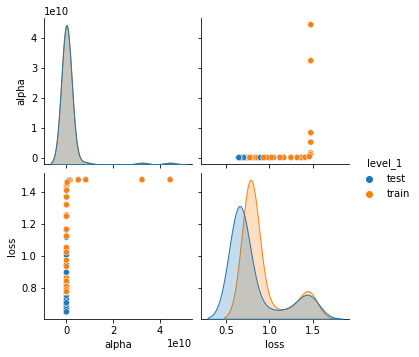

In [ ]:
run['hpo'] = {
    'min_params': hpo,
    'trials': File.as_html(hpo_df),
    'trials_pkl': File.as_pickle(hpo_df),
    'cross-dependency': File.as_image(sns.pairplot(data=hpo_df, hue='level_1').figure)
}

In [ ]:
train_x

,lag_1,lag_2,lag_6,lag_12,dynamic_aggregation_mean_win_2,dynamic_aggregation_min_win_2,dynamic_aggregation_max_win_2,dynamic_aggregation_mean_win_4,dynamic_aggregation_min_win_4,dynamic_aggregation_mean_win_6,...,diff_1_aggregation_mean_win_4,diff_2_aggregation_mean_win_4,diff_2_aggregation_mean_win_12,lags_12_aggregation_mean_win_2,lags_12_aggregation_min_win_2,lags_12_aggregation_mean_win_4,lags_12_aggregation_min_win_4,lags_12_aggregation_mean_win_6,shop_id,item_id
id,,,,,,,,,,,,,,,,,,,,,
0,-0.094532,-0.089297,-0.129906,-0.103544,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,0,0
1,-0.094532,-0.089297,-0.129906,0.316241,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,1,0
2,-0.094532,-0.089297,-0.129906,0.316241,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.675890,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,2,0
3,-0.094532,-0.089297,-0.129906,-0.103544,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,3,0
4,-0.094532,-0.089297,-0.129906,-0.103544,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422572,-0.094532,-0.089297,-0.129906,-0.103544,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,52,12796
422573,-0.094532,-0.089297,-0.129906,-0.103544,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.050699,53,12796
422574,-0.094532,-0.089297,-0.129906,-0.103544,-0.095305,-0.049158,-0.124438,-0.081358,-0.021676,-0.109337,...,0.028718,-0.002007,-0.008668,-0.097566,-0.051851,-0.100294,-0.022244,-0.103554,54,12796


In [ ]:
errors = {}

In [ ]:

validation_x['object_id'] = validation[validation.id.isin(train_objs)].id
validation_slice = validation_x.drop('object_id', axis=1)
slice_objs = validation_slice.index

lin_validator = Validator(Ridge, **hpo)

lin_validator.fit(test_x, test_y)

some = pd.Series(lin_validator.model.predict(validation_slice).transpose()[0], index = slice_objs)

validation_scheme = pd.DataFrame(validation_y_valid)
validation_scheme['predicted'] = some
print(
    validation_scheme['predicted'].isna().sum()
)
validation_scheme.fillna(0, inplace=True)
validation_scheme.loc[:,['valid_target']]

residulas = get_statistics(
    (0, 
    0, 
    validation_scheme.predicted,
    validation_scheme.loc[:,['valid_target']]))

run['params'] = hpo

from sklearn.metrics import mean_squared_error as mse

run['score/rmse/test'] = np.sqrt(mse(validation_scheme.predicted, validation_scheme.valid_target))
run['score/rmse/train'] = np.sqrt(lin_validator._train_err)
run['model'] = 'Ridge'
run['dump/residuals'].upload(File.as_pickle(residulas))
run['dump/model'].upload(File.as_pickle(lin_validator.model))

6847


/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


Did not log prediction error chart. Error: y must be a (1,) dimensional array not (415730, 1)
Did not log cooks distance chart. Error: shapes (415730,1) and (415730,1) not aligned: 1 (dim 1) != 415730 (dim 0)


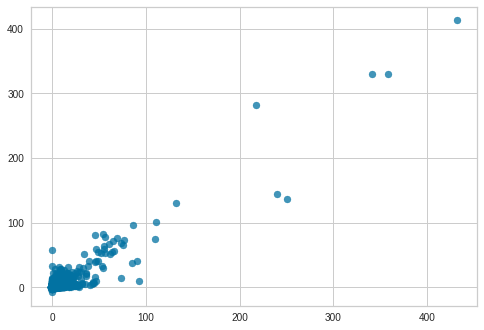

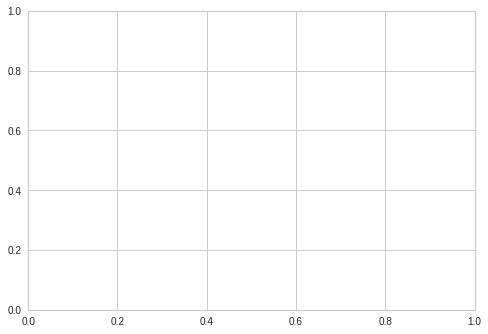

In [ ]:
import neptune.new.integrations.sklearn as npt_utils

run['auto_model_summary'] = npt_utils.create_regressor_summary(
    lin_validator.model, 
    train_x, 
    test_x, 
    train_y.to_numpy(), 
    test_y_valid.to_numpy())

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 23 operations to synchronize with Neptune. Do not kill this process.


All 23 operations synced, thanks for waiting!
